In [5]:
#print("123")
import pandas as pd
import seaborn as sns
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import scipy.stats as stats
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from collections import defaultdict
from tabulate import tabulate
from pathlib import Path
from collections import deque

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import random

np.random.seed(22)
random.seed(22)

#print(os.getcwd())
#print(os.listdir())

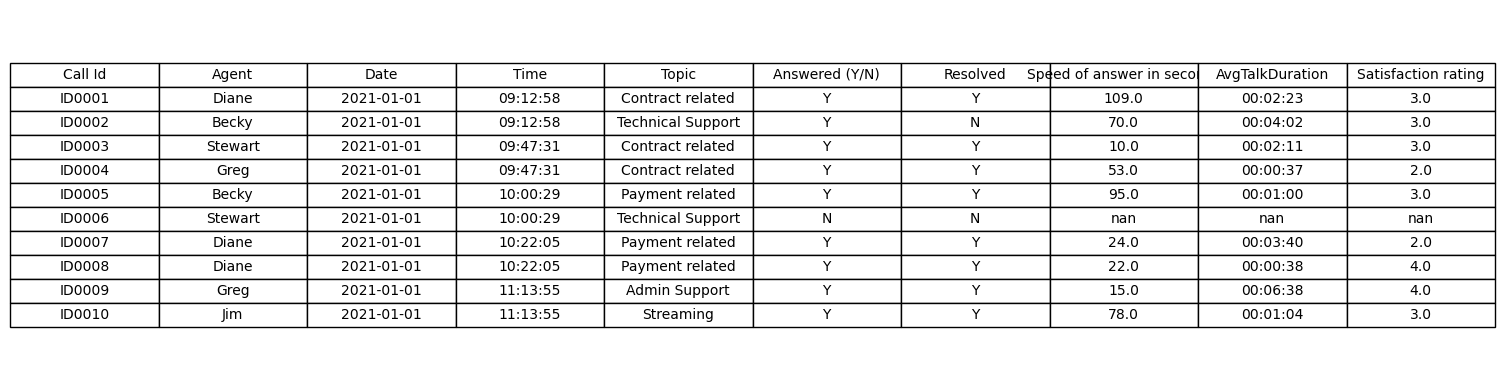

<Figure size 640x480 with 0 Axes>

['Contract related' 'Technical Support' 'Payment related' 'Admin Support'
 'Streaming'] ['Diane' 'Becky' 'Stewart' 'Greg' 'Jim' 'Joe' 'Martha' 'Dan']


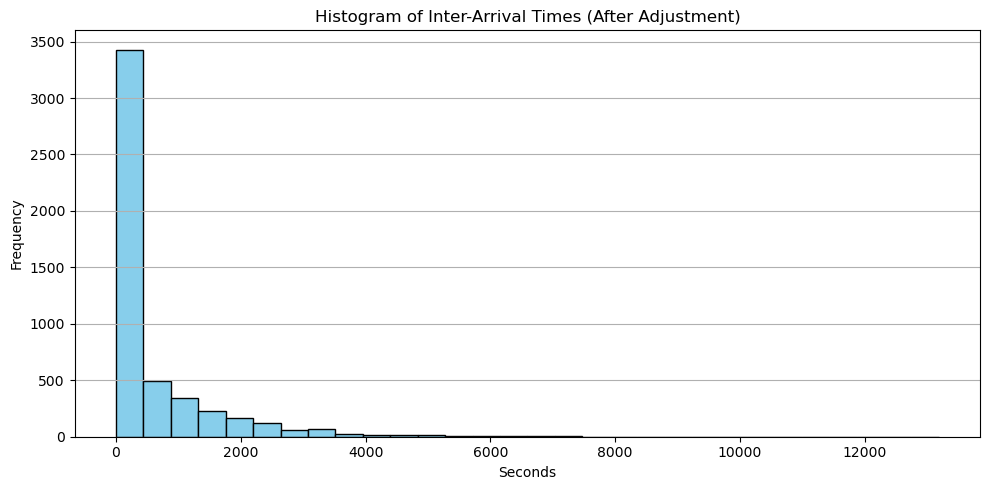

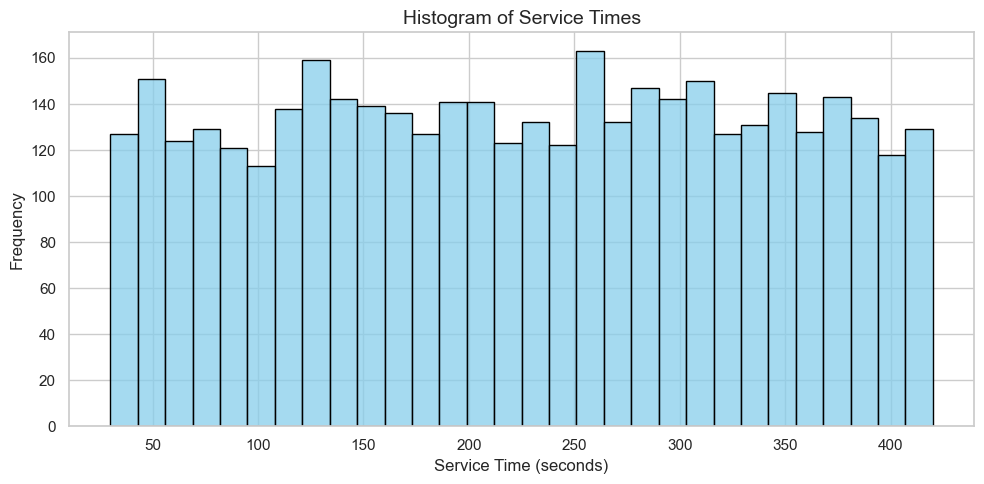

In [7]:
df = pd.read_excel("call_center_dataset.xlsx")
# print top 10 rows
top_10 = df.head(10)

# output tables
fig, ax = plt.subplots(figsize=(15, 4)) 
ax.axis('off')

table = ax.table(
    cellText=top_10.values,
    colLabels=top_10.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.1]*len(top_10.columns) 
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  

plt.tight_layout()
plt.savefig("top_10_call_data.png", bbox_inches='tight')
plt.show()

plt.savefig("top10_calls.png", bbox_inches="tight")
plt.show()
# Data cleaning

# Remove the spaces and replace the brackets
df.columns = df.columns.str.strip().str.replace('[^a-zA-Z0-9_]', '_', regex=True)

# Date, Time formate exchange
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.time

# Replace Y/N to 1/0
df['Answered__Y_N_'] = df['Answered__Y_N_'].astype(str).str.strip().str.upper().map({'Y': 1, 'N': 0})
df['Resolved'] = df['Resolved'].astype(str).str.strip().str.upper().map({'Y': 1, 'N': 0})

# Convert time to secnonds
def time_to_seconds(t):
    if pd.isna(t):
        return np.nan
    return t.hour * 3600 + t.minute * 60 + t.second
df['AvgTalkDuration'] = df['AvgTalkDuration'].apply(time_to_seconds).astype('Int64')

# Drop duplicates
df.drop_duplicates(inplace=True)

df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Mark the duplicated row
df['Is_Duplicate'] = df.duplicated(subset=['DateTime'], keep='first')

# Adding random 1-59s to the duplicated row
import numpy as np
df.loc[df['Is_Duplicate'], 'DateTime'] += pd.to_timedelta(
    np.random.randint(1, 60, size=df['Is_Duplicate'].sum()), unit='s'
)

# Reorder by DateTime
df = df.sort_values(by='DateTime').reset_index(drop=True)

# Create Adjusted arrical
df['Adjusted_arrival'] = df['DateTime']

# Calculate the inter-arrival
df['Inter_arrival_time'] = df.groupby(df['Adjusted_arrival'].dt.date)['Adjusted_arrival'].diff().dt.total_seconds()
df['Inter_arrival_time'] = df['Inter_arrival_time'].fillna(0)
unique_topics = df['Topic'].unique()
unique_Agent = df['Agent'].unique()
print(unique_topics,unique_Agent)

# Output the csv cleaned data
df.to_csv("cleaned_call_center_dataset.csv", index=False)

# Plot inter-arrival times
plt.figure(figsize=(10, 5))
plt.hist(df['Inter_arrival_time'], bins=30, edgecolor='black', color='skyblue')
plt.title("Histogram of Inter-Arrival Times (After Adjustment)")
plt.xlabel("Seconds")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("inter_arrival_histogram.png")
plt.show()

# Plot services times
service_times = df['AvgTalkDuration'].dropna().astype(float)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(service_times, bins=30, color="skyblue", edgecolor='black')
plt.title("Histogram of Service Times", fontsize=14)
plt.xlabel("Service Time (seconds)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

In [9]:
#Data Analysis

df = pd.read_csv("cleaned_call_center_dataset.csv")
average_speed_answer = df["Speed_of_answer_in_seconds"].mean()

answered_count = (df["Answered__Y_N_"] == 1).sum()
answered_calls = (answered_count / 5000) * 100
#print(answered_count)
average_talking = df['AvgTalkDuration'].mean()

print(answered_calls,average_speed_answer, average_talking)

#Group analysis, what type of calls assigned to that person, and how many calls are not solved
call_counts = df.groupby(["Agent", "Topic"]).size().reset_index(name="Call Count")

unresolved_answered = df[
    (df["Answered__Y_N_"] == 1) & (df["Resolved"] == 0)
].groupby(["Agent", "Topic"]).size().reset_index(name="Unresolved Answered Count")

result = pd.merge(call_counts, unresolved_answered, on=["Agent", "Topic"], how="left")
result["Unresolved Answered Count"] = result["Unresolved Answered Count"].fillna(0).astype(int)

print(result)

81.08 67.52072027627035 224.92279230389738
      Agent              Topic  Call Count  Unresolved Answered Count
0     Becky      Admin Support         121                         10
1     Becky   Contract related         114                          9
2     Becky    Payment related         138                         13
3     Becky          Streaming         137                         14
4     Becky  Technical Support         121                          9
5       Dan      Admin Support         108                          7
6       Dan   Contract related         123                         10
7       Dan    Payment related         130                         13
8       Dan          Streaming         132                         13
9       Dan  Technical Support         140                          9
10    Diane      Admin Support         134                          5
11    Diane   Contract related         123                         10
12    Diane    Payment related         125     

Augmented dataset saved: call_center_augmented_x2.csv, total 10000 rows
  Call_Id  Agent        Date      Time             Topic  Answered__Y_N_  \
0  ID2934   Greg  2021-02-20  16:16:19  Contract related               1   
1  ID4909    Jim  2021-03-29  12:00:00  Contract related               1   
2  ID0357  Becky  2021-01-07  10:48:00         Streaming               0   
3  ID4588    Dan  2021-03-22  17:39:50   Payment related               0   
4  ID2953    Joe  2021-02-21  11:12:29   Payment related               1   
5  ID2528    Jim  2021-02-13  15:57:36   Payment related               1   
6  ID0990    Jim  2021-01-18  11:58:34         Streaming               1   
7  ID0765   Greg  2021-01-14  09:24:29     Admin Support               1   
8  ID3630    Jim  2021-03-04  17:15:22  Contract related               1   
9  ID1019    Joe  2021-01-18  17:18:14  Contract related               1   

   Resolved  Speed_of_answer_in_seconds  AvgTalkDuration  Satisfaction_rating  \
0         

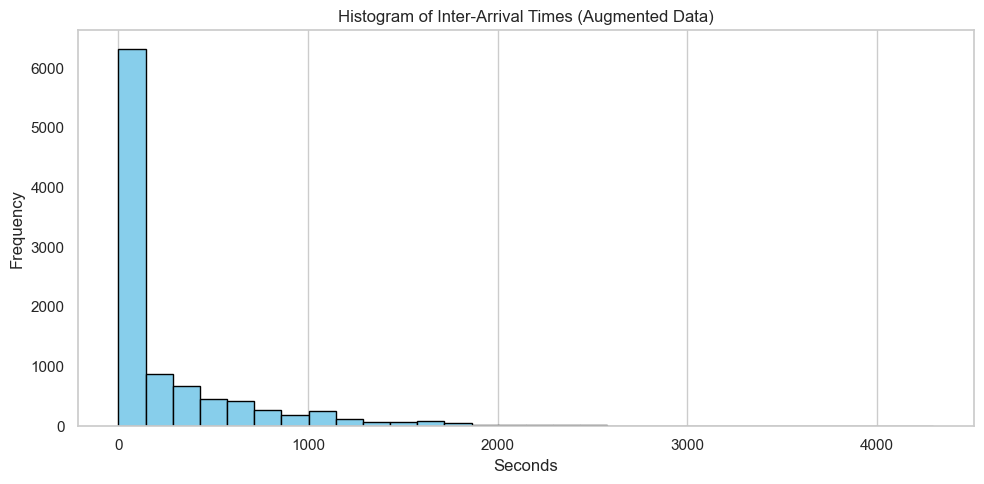

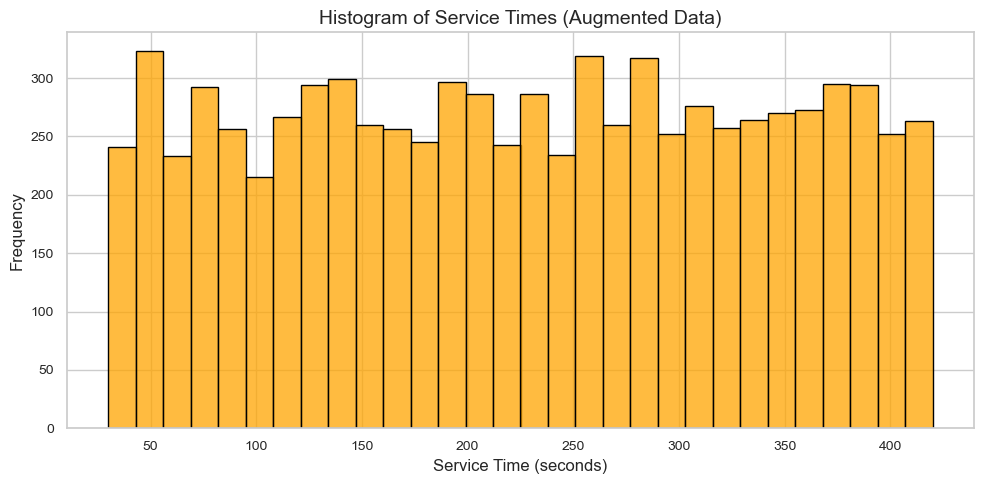

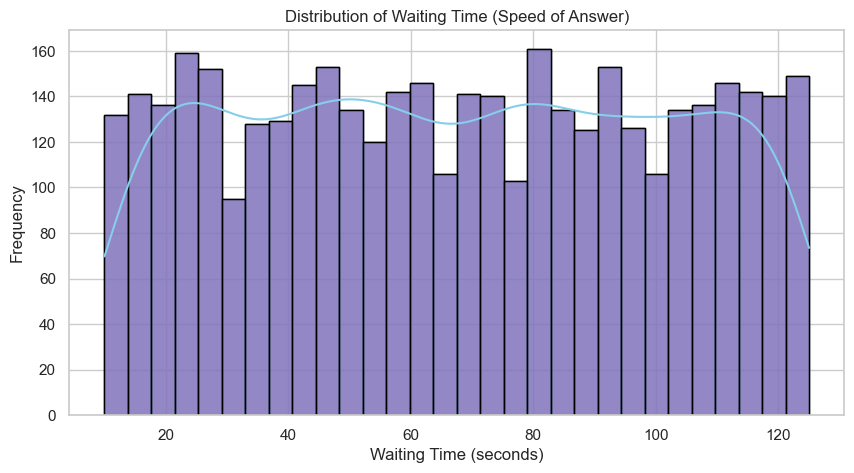

In [11]:
df = pd.read_csv("cleaned_call_center_dataset.csv")
df = df.sort_values('Adjusted_arrival').reset_index(drop=True)

# rate to create new data
rate = 2.0  
np.random.seed(22) 

# create new lens
n_new = int(len(df) * rate)  
# empirical sample
idx_sample = np.random.choice(df.index, size=n_new, replace=True)
df_sampled = df.loc[idx_sample].reset_index(drop=True)

inter_arrival_scaled = np.random.choice(
    df['Inter_arrival_time'].clip(lower=0), 
    size=n_new, 
    replace=True
) / rate

# Generate new arrival time
start_time = pd.to_datetime(df['Adjusted_arrival'].iloc[0])
arrival_times = [start_time]
for gap in inter_arrival_scaled[1:]:
    arrival_times.append(arrival_times[-1] + pd.to_timedelta(gap, unit='s'))
arrival_times = pd.to_datetime(arrival_times)

df_sampled['Adjusted_arrival'] = arrival_times
df_sampled['Inter_arrival_time'] = np.r_[0, np.diff(arrival_times) / np.timedelta64(1, 's')]

# Reorder
df_sampled = df_sampled.sort_values('Adjusted_arrival').reset_index(drop=True)

# Output
output_file = f"call_center_augmented_x{int(rate)}.csv"
df_sampled.to_csv(output_file, index=False)
print(f"Augmented dataset saved: {output_file}, total {len(df_sampled)} rows")
print(df_sampled.head(10))

# Plot the Inter-arrival time after augented 
plt.figure(figsize=(10, 5))
plt.hist(df_sampled['Inter_arrival_time'], bins=30, edgecolor='black', color='skyblue')
plt.title("Histogram of Inter-Arrival Times (Augmented Data)")
plt.xlabel("Seconds")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot the service time after augmented
service_times = df_sampled['AvgTalkDuration'].dropna().astype(float)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(service_times, bins=30, color="orange", edgecolor='black')

plt.title("Histogram of Service Times (Augmented Data)", fontsize=14)
plt.xlabel("Service Time (seconds)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
sns.histplot(df['Speed_of_answer_in_seconds'], bins=30, color="purple", edgecolor='black')
plt.title("Distribution of Waiting Time (Speed of Answer)")
plt.xlabel("Waiting Time (seconds)")
plt.ylabel("Frequency")
sns.histplot(df['Speed_of_answer_in_seconds'], bins=30, kde=True, color="skyblue", edgecolor='black')
plt.show()

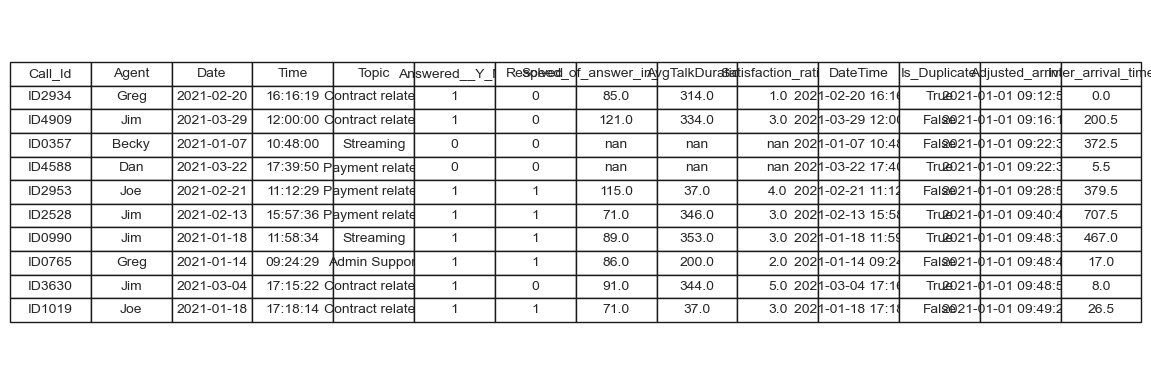

<Figure size 640x480 with 0 Axes>

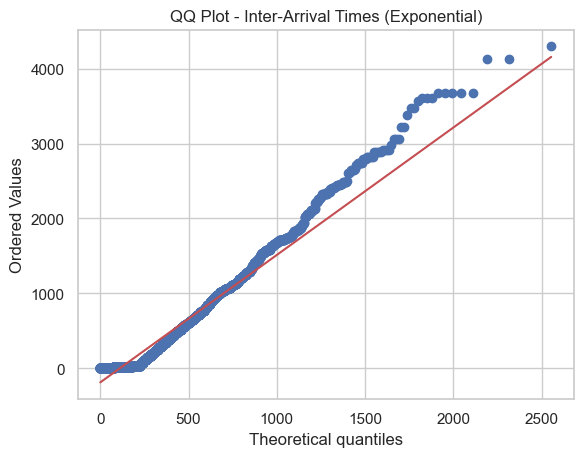

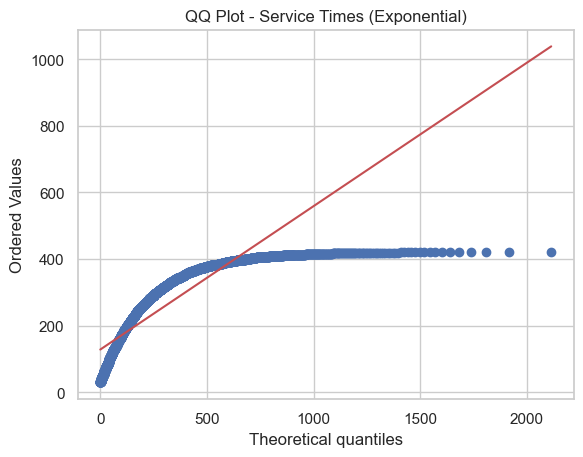

In [13]:
df = pd.read_csv("call_center_augmented_x2.csv")
top_10 = df.head(10)

fig, ax = plt.subplots(figsize=(15, 4)) 
ax.axis('off')
table = ax.table(
    cellText=top_10.values,
    colLabels=top_10.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.1]*len(top_10.columns) 
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  

plt.tight_layout()
plt.savefig("top_10_call_data.png", bbox_inches='tight')
plt.show()

# QQ plot for arrival time
plt.savefig("top10_calls.png", bbox_inches="tight")
plt.show()
# --- Arrival time ---
arrival_times = df['Inter_arrival_time'].dropna()
arrival_rate = 1 / np.mean(arrival_times)  # λ = 1/mean
stats.probplot(arrival_times, dist=stats.expon(scale=1/arrival_rate), plot=plt)
plt.title("QQ Plot - Inter-Arrival Times (Exponential)")
plt.show()

# QQ plot for service time
service_times = df['AvgTalkDuration'].dropna()
service_rate = 1 / np.mean(service_times)  # λ = 1/mean
stats.probplot(service_times, dist=stats.expon(scale=1/service_rate), plot=plt)
plt.title("QQ Plot - Service Times (Exponential)")
plt.show()

In [56]:
# Load data
p_aug = Path("call_center_augmented_x2.csv")
p_clean = Path("cleaned_call_center_dataset.csv")
if p_aug.exists():
    df = pd.read_csv(p_aug)
else:
    df = pd.read_csv(p_clean)
    
# Ensure datetime
df['Adjusted_arrival'] = pd.to_datetime(df['Adjusted_arrival'], errors='coerce')

# Call type mapping
type2_topics = {"Technical Support", "Streaming"}
df['call_type'] = np.where(df['Topic'].isin(type2_topics), 2, 1)

df['hour'] = df['Adjusted_arrival'].dt.hour
# filter out non-positive/NaN gaps
def inv_mean_positive_seconds(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    s = s[s > 0]
    return (1.0 / s.mean()) if len(s) else np.nan  # per second

lambda_by_hour = df.groupby('hour')['Inter_arrival_time'].apply(inv_mean_positive_seconds).to_dict()
global_lambda = inv_mean_positive_seconds(df['Inter_arrival_time'])

def inv_mean_seconds(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    return (1.0 / s.mean()) if len(s) else np.nan

mu_by_type = df.groupby('call_type')['AvgTalkDuration'].apply(inv_mean_seconds).to_dict()
# Optional: global μ if you don’t split by type
global_mu = inv_mean_seconds(df['AvgTalkDuration'])

# MDP environment parameters
MDP_PARAMS = {
    "agents": {"n_type1": 1, "n_type2": 1},   
    "queue_cap": 100,
    "lambda_by_hour": lambda_by_hour, 
    "global_lambda": global_lambda, 
    "mu_by_type": mu_by_type, 
    "global_mu": global_mu, 
    "type_rule": {"type2_topics": sorted(type2_topics)},
}


for h, val in list(MDP_PARAMS["lambda_by_hour"].items()):
    if not np.isfinite(val):
        MDP_PARAMS["lambda_by_hour"][h] = MDP_PARAMS["global_lambda"]
print(MDP_PARAMS)  

{'agents': {'n_type1': 1, 'n_type2': 1}, 'queue_cap': 100, 'lambda_by_hour': {0: 0.003463018582390597, 1: 0.003717391209719193, 2: 0.0032342598606849285, 3: 0.00402825099375355, 4: 0.0033165657771336, 5: 0.003888777048359299, 6: 0.0035541254215410907, 7: 0.004184082220260179, 8: 0.0034897873797116886, 9: 0.003838082010524056, 10: 0.003949200215927494, 11: 0.003393419601206746, 12: 0.0037226539350789186, 13: 0.0038519090601921123, 14: 0.003605045265343918, 15: 0.0036542132533406053, 16: 0.0032272313420053907, 17: 0.003087687737036252, 18: 0.003706164774588438, 19: 0.003395044910995335, 20: 0.004065118967344187, 21: 0.004158170050536395, 22: 0.0038963224029682896, 23: 0.0037050097981885625}, 'global_lambda': 0.0036688477823657644, 'mu_by_type': {1: 0.004469303135224766, 2: 0.0043870939170244155}, 'global_mu': 0.00443675365743133, 'type_rule': {'type2_topics': ['Streaming', 'Technical Support']}}


In [64]:
#Load data
p_aug = Path("call_center_augmented_x2.csv")
p_clean = Path("cleaned_call_center_dataset.csv")
df = pd.read_csv(p_aug if p_aug.exists() else p_clean)
df['Adjusted_arrival'] = pd.to_datetime(df['Adjusted_arrival'], errors='coerce')

type2_topics = {"Technical Support", "Streaming"}
df['call_type'] = np.where(df['Topic'].isin(type2_topics), 2, 1)

def inv_mean_positive_seconds(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    s = s[s > 0]
    return (1.0 / s.mean()) if len(s) else np.nan

def inv_mean_seconds(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    return (1.0 / s.mean()) if len(s) else np.nan

df['hour'] = df['Adjusted_arrival'].dt.hour
lambda_by_hour = df.groupby('hour')['Inter_arrival_time'].apply(inv_mean_positive_seconds).to_dict()
global_lambda  = inv_mean_positive_seconds(df['Inter_arrival_time'])

# empirical service-time
svc_pool_type1 = df.loc[df['call_type']==1, 'AvgTalkDuration'].dropna().astype(float).values
svc_pool_type2 = df.loc[df['call_type']==2, 'AvgTalkDuration'].dropna().astype(float).values
svc_pool_all   = df['AvgTalkDuration'].dropna().astype(float).values

#  Helpers
rng = np.random.default_rng(42)

def sample_service_time(call_type):
    if call_type == 1 and len(svc_pool_type1):
        return float(rng.choice(svc_pool_type1))
    if call_type == 2 and len(svc_pool_type2):
        return float(rng.choice(svc_pool_type2))
    return float(rng.choice(svc_pool_all))  # fallback

def rate_at(ts):
    h = ts.hour
    lam = lambda_by_hour.get(h, np.nan)
    if not np.isfinite(lam) or lam <= 0:
        lam = global_lambda
    return lam

def sample_next_arrival(current_ts):
    """
    Approximate NHPP with piecewise-constant per hour:
    draw Exp(rate_at(current_ts)); if it crosses hour boundary, redraw with new hour's rate.
    """
    t = current_ts
    while True:
        lam = rate_at(t)
        gap = rng.exponential(1.0/lam)  # seconds
        next_t = t + pd.to_timedelta(gap, unit='s')
        # if crosses into a new hour, accept anyway and rely on new rate next iteration
        return next_t

# Simulator (FCFS baseline)
def simulate_fcfs(
    start_ts, hours=8, queue_cap=50, max_calls=10000
):
    """
    Two agents:
      - agent1 (specialist): can serve type-1 only
      - agent2 (generalist): can serve type-1 and type-2
    Routing (FCFS within type):
      - agent1 always takes type-1 if available
      - agent2 prefers type-2; if none, helps type-1
    """
    # state
    end_ts = start_ts + pd.Timedelta(hours=hours)
    now = start_ts

    q1, q2 = deque(), deque()
    agent1_free_at = start_ts
    agent2_free_at = start_ts
    busy1 = False
    busy2 = False

    # metrics
    waits = []
    served = 0
    dropped = 0
    arrivals = 0
    util_time1 = 0.0
    util_time2 = 0.0

    # event pointers
    next_arrival = sample_next_arrival(now)
    next_finish1 = pd.Timestamp.max
    next_finish2 = pd.Timestamp.max

    while now < end_ts and served < max_calls:
        next_event = min(next_arrival, next_finish1, next_finish2)
        if next_event > end_ts:
            now = end_ts
            break

        delta = (next_event - now).total_seconds()
        # accumulate utilization
        if busy1: util_time1 += delta
        if busy2: util_time2 += delta
        now = next_event

        if now == next_arrival:

            call_type = int(rng.choice(df['call_type'].values))
            arrivals += 1
            # enqueue or drop
            if (len(q1) + len(q2)) >= queue_cap:
                dropped += 1
            else:
                if call_type == 1:
                    q1.append((now, 1))
                else:
                    q2.append((now, 2))
            # schedule next arrival
            next_arrival = sample_next_arrival(now)

        if now == next_finish1:
            busy1 = False
            next_finish1 = pd.Timestamp.max

        if now == next_finish2:
            busy2 = False
            next_finish2 = pd.Timestamp.max

        # try to start new services 
        # agent1:
        if (not busy1) and q1:
            arr_ts, _ = q1.popleft()
            wait = (now - arr_ts).total_seconds()
            svc = sample_service_time(1)
            next_finish1 = now + pd.to_timedelta(svc, unit='s')
            busy1 = True
            waits.append(wait)
            served += 1

        # agent2:
        if (not busy2):
            picked = None
            if q2:
                picked = q2.popleft()
                ctype = 2
            elif q1:
                picked = q1.popleft()
                ctype = 1
            if picked:
                arr_ts, _ = picked
                wait = (now - arr_ts).total_seconds()
                svc = sample_service_time(ctype)
                next_finish2 = now + pd.to_timedelta(svc, unit='s')
                busy2 = True
                waits.append(wait)
                served += 1

    # finalize utilization ratio over the simulated horizon
    horizon_secs = (min(now, end_ts) - start_ts).total_seconds()
    util1 = util_time1 / horizon_secs if horizon_secs > 0 else 0.0
    util2 = util_time2 / horizon_secs if horizon_secs > 0 else 0.0

    out = {
        "avg_wait_sec": float(np.mean(waits)) if waits else 0.0,
        "served": served,
        "arrivals": arrivals,
        "dropped": dropped,
        "drop_rate": dropped / arrivals if arrivals else 0.0,
        "utilization_agent1": util1,
        "utilization_agent2": util2,
    }
    return out

# Run a quick baseline
start_ts = df['Adjusted_arrival'].min().normalize() + pd.Timedelta(hours=9)  
res = simulate_fcfs(start_ts=start_ts, hours=8, queue_cap=50, max_calls=20000)
print("FCFS baseline (8h):", res)

FCFS baseline (8h): {'avg_wait_sec': 49.520724703703706, 'served': 108, 'arrivals': 108, 'dropped': 0, 'drop_rate': 0.0, 'utilization_agent1': 0.4174652759722222, 'utilization_agent2': 0.4538194422569445}


In [66]:

#  Load
p_aug = Path("call_center_augmented_x2.csv")
p_clean = Path("cleaned_call_center_dataset.csv")
df = pd.read_csv(p_aug if p_aug.exists() else p_clean)
df['Adjusted_arrival'] = pd.to_datetime(df['Adjusted_arrival'], errors='coerce')

type2_topics = {"Technical Support", "Streaming"}
df['call_type'] = np.where(df['Topic'].isin(type2_topics), 2, 1)

def inv_mean_positive_seconds(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    s = s[s > 0]
    return (1.0 / s.mean()) if len(s) else np.nan

df['hour'] = df['Adjusted_arrival'].dt.hour
lambda_by_hour = df.groupby('hour')['Inter_arrival_time'].apply(inv_mean_positive_seconds).to_dict()
global_lambda  = inv_mean_positive_seconds(df['Inter_arrival_time'])

svc_pool_type1 = df.loc[df['call_type']==1, 'AvgTalkDuration'].dropna().astype(float).values
svc_pool_type2 = df.loc[df['call_type']==2, 'AvgTalkDuration'].dropna().astype(float).values
svc_pool_all   = df['AvgTalkDuration'].dropna().astype(float).values

# Environment 
class CallCenterEnv:
    """
    Obs: [q1, q2, b1_busy, b2_busy, sin_hour, cos_hour]
    Act: 0 -> agent2 prefer type-2; 1 -> agent2 prefer type-1
    Reward: - (q1 + q2) * dt
    """
    def __init__(self, start_ts=None, hours=8, dt=5.0, queue_cap=50, seed=42):
        self.dt = float(dt)
        self.queue_cap = int(queue_cap)
        self.horizon = int(hours * 3600 / self.dt)  # steps
        self.rng = np.random.default_rng(seed)

        # start at first day 09:00 if not given
        if start_ts is None:
            start_ts = df['Adjusted_arrival'].min().normalize() + pd.Timedelta(hours=9)
        self.start_ts = pd.Timestamp(start_ts)

        # queues and servers
        self.q1 = deque()
        self.q2 = deque()
        self.b1_free_in = 0.0
        self.b2_free_in = 0.0 

        # stats
        self.waits = []
        self.served = 0
        self.dropped = 0
        self.arrivals = 0

        self.t_step = 0
        self.now = self.start_ts

    def _rate_at_hour(self, ts):
        h = ts.hour
        lam = lambda_by_hour.get(h, np.nan)
        if not np.isfinite(lam) or lam <= 0:
            lam = global_lambda
        return lam

    def _sample_service_time(self, ctype):
        if ctype == 1 and len(svc_pool_type1):
            return float(self.rng.choice(svc_pool_type1))
        if ctype == 2 and len(svc_pool_type2):
            return float(self.rng.choice(svc_pool_type2))
        return float(self.rng.choice(svc_pool_all))

    def _arrivals_this_step(self):
        lam = self._rate_at_hour(self.now)
        mean = lam * self.dt
        k = self.rng.poisson(mean) if mean > 0 else 0
        return int(k)

    def reset(self):
        self.q1.clear(); self.q2.clear()
        self.b1_free_in = 0.0
        self.b2_free_in = 0.0
        self.waits.clear()
        self.served = 0
        self.dropped = 0
        self.arrivals = 0
        self.t_step = 0
        self.now = self.start_ts
        return self._obs()

    def _obs(self):
        q1_len = len(self.q1)
        q2_len = len(self.q2)
        b1_busy = 1.0 if self.b1_free_in > 0 else 0.0
        b2_busy = 1.0 if self.b2_free_in > 0 else 0.0
        h = self.now.hour + self.now.minute/60.0
        sin_h = np.sin(2*np.pi*h/24.0)
        cos_h = np.cos(2*np.pi*h/24.0)
        return np.array([q1_len, q2_len, b1_busy, b2_busy, sin_h, cos_h], dtype=float)

    def step(self, action):
        """
        action: 0 -> agent2 prefer type-2, else type-1
        1) arrivals
        2) service completions (count down)
        3) start service if idle
        4) advance time
        reward = - (q1+q2) * dt
        """
        # 1) arrivals
        k = self._arrivals_this_step()
        self.arrivals += k
        # decide call types by empirical proportion
        if k > 0:
            types_drawn = self.rng.choice(df['call_type'].values, size=k, replace=True)
            for ctype in types_drawn:
                if (len(self.q1) + len(self.q2)) >= self.queue_cap:
                    self.dropped += 1
                else:
                    if ctype == 1:
                        self.q1.append(self.now)  # store arrival ts
                    else:
                        self.q2.append(self.now)

        # reduce remaining time
        self.b1_free_in = max(0.0, self.b1_free_in - self.dt)
        self.b2_free_in = max(0.0, self.b2_free_in - self.dt)

        # agent1:
        if self.b1_free_in <= 1e-9 and self.q1:
            arr_ts = self.q1.popleft()
            wait = (self.now - arr_ts).total_seconds()
            svc = self._sample_service_time(1)
            self.b1_free_in = svc
            self.waits.append(wait); self.served += 1

        # agent2: 
        if self.b2_free_in <= 1e-9:
            picked = None; ctype = None
            if action == 0:
                # prefer type-2
                if self.q2:
                    picked = self.q2.popleft(); ctype = 2
                elif self.q1:
                    picked = self.q1.popleft(); ctype = 1
            else:
                if self.q1:
                    picked = self.q1.popleft(); ctype = 1
                elif self.q2:
                    picked = self.q2.popleft(); ctype = 2
            if picked is not None:
                wait = (self.now - picked).total_seconds()
                svc = self._sample_service_time(ctype)
                self.b2_free_in = svc
                self.waits.append(wait); self.served += 1

        # 4) reward
        q_len = len(self.q1) + len(self.q2)
        reward = - float(q_len) * self.dt
        self.t_step += 1
        self.now += pd.to_timedelta(self.dt, unit='s')
        done = (self.t_step >= self.horizon)
        info = {
            "q1": len(self.q1),
            "q2": len(self.q2),
            "served": self.served,
            "arrivals": self.arrivals,
            "dropped": self.dropped,
            "avg_wait": float(np.mean(self.waits)) if self.waits else 0.0
        }
        return self._obs(), reward, done, info


env = CallCenterEnv(hours=8, dt=5.0, queue_cap=50, seed=123)
obs = env.reset()
total_reward = 0.0
while True:
    action = env.rng.integers(0, 2)  # random 0/1
    obs, r, done, info = env.step(action)
    total_reward += r
    if done:
        break

print({
    "episode_steps": env.t_step,
    "avg_wait_sec": info["avg_wait"],
    "served": info["served"],
    "arrivals": info["arrivals"],
    "dropped": info["dropped"],
    "total_reward": total_reward
})

{'episode_steps': 5760, 'avg_wait_sec': 31.529411764705884, 'served': 85, 'arrivals': 85, 'dropped': 0, 'total_reward': -2680.0}


In [74]:

# Training & Evaluation for Q-learning and PPO

import numpy as np
import pandas as pd
from collections import deque
from pathlib import Path

p_aug = Path("call_center_augmented_x2.csv")
p_clean = Path("cleaned_call_center_dataset.csv")
df = pd.read_csv(p_aug if p_aug.exists() else p_clean)
df['Adjusted_arrival'] = pd.to_datetime(df['Adjusted_arrival'], errors='coerce')

type2_topics = {"Technical Support", "Streaming"}
df['call_type'] = np.where(df['Topic'].isin(type2_topics), 2, 1)

def inv_mean_positive_seconds(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    s = s[s > 0]
    return (1.0 / s.mean()) if len(s) else np.nan

df['hour'] = df['Adjusted_arrival'].dt.hour
lambda_by_hour = df.groupby('hour')['Inter_arrival_time'].apply(inv_mean_positive_seconds).to_dict()
global_lambda  = inv_mean_positive_seconds(df['Inter_arrival_time'])

svc_pool_type1 = df.loc[df['call_type']==1, 'AvgTalkDuration'].dropna().astype(float).values
svc_pool_type2 = df.loc[df['call_type']==2, 'AvgTalkDuration'].dropna().astype(float).values
svc_pool_all   = df['AvgTalkDuration'].dropna().astype(float).values

# Environment
import gym
from gym import spaces

class CallCenterEnv(gym.Env):
    """
    Obs: [q1, q2, b1_busy, b2_busy, sin_hour, cos_hour]
    Act: 0 -> agent2 prefer type-2; 1 -> agent2 prefer type-1
    Reward: - (q1 + q2) * dt
    """
    metadata = {"render.modes": []}
    def __init__(self, start_ts=None, hours=8, dt=5.0, queue_cap=50, seed=42):
        super().__init__()
        self.dt = float(dt)
        self.queue_cap = int(queue_cap)
        self.horizon = int(hours * 3600 / self.dt)
        self.np_random = np.random.default_rng(seed)

        if start_ts is None:
            start_ts = df['Adjusted_arrival'].min().normalize() + pd.Timedelta(hours=9)
        self.start_ts = pd.Timestamp(start_ts)

        self.q1 = deque()
        self.q2 = deque()
        self.b1_free_in = 0.0
        self.b2_free_in = 0.0
        self.waits = []
        self.served = 0
        self.dropped = 0
        self.arrivals = 0
        self.t_step = 0
        self.now = self.start_ts

        # Gym spaces
        # queues capped for observation
        self.max_obs_q = 100
        low  = np.array([0, 0, 0, 0, -1.0, -1.0], dtype=np.float32)
        high = np.array([self.max_obs_q, self.max_obs_q, 1, 1,  1.0,  1.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.action_space = spaces.Discrete(2)

    def _rate_at_hour(self, ts):
        h = ts.hour
        lam = lambda_by_hour.get(h, np.nan)
        if not np.isfinite(lam) or lam <= 0:
            lam = global_lambda
        return lam

    def _sample_service_time(self, ctype):
        if ctype == 1 and len(svc_pool_type1):
            return float(self.np_random.choice(svc_pool_type1))
        if ctype == 2 and len(svc_pool_type2):
            return float(self.np_random.choice(svc_pool_type2))
        return float(self.np_random.choice(svc_pool_all))

    def _arrivals_this_step(self):
        lam = self._rate_at_hour(self.now)
        mean = lam * self.dt
        return int(self.np_random.poisson(mean) if mean > 0 else 0)

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.np_random = np.random.default_rng(seed)
        self.q1.clear(); self.q2.clear()
        self.b1_free_in = 0.0; self.b2_free_in = 0.0
        self.waits.clear(); self.served = 0; self.dropped = 0; self.arrivals = 0
        self.t_step = 0
        self.now = self.start_ts
        return self._obs(), {}

    def _obs(self):
        q1_len = min(len(self.q1), self.max_obs_q)
        q2_len = min(len(self.q2), self.max_obs_q)
        b1_busy = 1.0 if self.b1_free_in > 0 else 0.0
        b2_busy = 1.0 if self.b2_free_in > 0 else 0.0
        h = self.now.hour + self.now.minute/60.0
        sin_h = np.sin(2*np.pi*h/24.0)
        cos_h = np.cos(2*np.pi*h/24.0)
        return np.array([q1_len, q2_len, b1_busy, b2_busy, sin_h, cos_h], dtype=np.float32)

    def step(self, action):
        # Arrivals
        k = self._arrivals_this_step()
        self.arrivals += k
        if k > 0:
            types_drawn = self.np_random.choice(df['call_type'].values, size=k, replace=True)
            for ctype in types_drawn:
                if (len(self.q1) + len(self.q2)) >= self.queue_cap:
                    self.dropped += 1
                else:
                    (self.q1 if ctype==1 else self.q2).append(self.now)

        # Service countdown
        self.b1_free_in = max(0.0, self.b1_free_in - self.dt)
        self.b2_free_in = max(0.0, self.b2_free_in - self.dt)

        # Start service if idle
        if self.b1_free_in <= 1e-9 and self.q1:
            arr_ts = self.q1.popleft()
            wait = (self.now - arr_ts).total_seconds()
            self.b1_free_in = self._sample_service_time(1)
            self.waits.append(wait); self.served += 1

        if self.b2_free_in <= 1e-9:
            picked = None; ctype = None
            if action == 0:
                if self.q2: picked = self.q2.popleft(); ctype = 2
                elif self.q1: picked = self.q1.popleft(); ctype = 1
            else:
                if self.q1: picked = self.q1.popleft(); ctype = 1
                elif self.q2: picked = self.q2.popleft(); ctype = 2
            if picked is not None:
                wait = (self.now - picked).total_seconds()
                self.b2_free_in = self._sample_service_time(ctype)
                self.waits.append(wait); self.served += 1

        # Reward & advance
        q_len = len(self.q1) + len(self.q2)
        reward = - float(q_len) * self.dt
        self.t_step += 1
        self.now += pd.to_timedelta(self.dt, unit='s')
        done = (self.t_step >= self.horizon)

        info = {
            "avg_wait": float(np.mean(self.waits)) if self.waits else 0.0,
            "served": self.served,
            "arrivals": self.arrivals,
            "dropped": self.dropped,
            "drop_rate": self.dropped / self.arrivals if self.arrivals else 0.0
        }
        return self._obs(), reward, done, False, info

# helper
def evaluate_policy(env, policy_fn, episodes=5, seed=123):
    metrics = []
    for ep in range(episodes):
        obs, _ = env.reset(seed=seed+ep)
        done = False
        total_r = 0.0
        while not done:
            act = policy_fn(obs)
            obs, r, done, _, info = env.step(act)
            total_r += r
        metrics.append({
            "avg_wait": info["avg_wait"],
            "served": info["served"],
            "arrivals": info["arrivals"],
            "drop_rate": info["drop_rate"],
            "total_reward": total_r
        })
    return pd.DataFrame(metrics)

#  Q-learning
class QLearner:
    def __init__(self, q_bins=(10,10), alpha=0.3, gamma=0.95, eps=0.1, eps_decay=0.999):
        self.q_bins = q_bins
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        self.Q = np.zeros((q_bins[0], q_bins[1], 2))  # actions=2

    def _disc(self, obs):
        q1, q2 = int(obs[0]), int(obs[1])
        i = min(q1, self.q_bins[0]-1)
        j = min(q2, self.q_bins[1]-1)
        return i, j

    def act(self, obs, rng):
        if rng.random() < self.eps:
            return rng.integers(0, 2)
        i,j = self._disc(obs)
        return int(np.argmax(self.Q[i,j,:]))

    def update(self, o, a, r, o2, done):
        i,j = self._disc(o); i2,j2 = self._disc(o2)
        best_next = 0.0 if done else np.max(self.Q[i2,j2,:])
        td = r + self.gamma*best_next - self.Q[i,j,a]
        self.Q[i,j,a] += self.alpha * td

    def decay(self):
        self.eps = max(0.01, self.eps * self.eps_decay)

def train_qlearning(env, episodes=200, seed=0):
    rng = np.random.default_rng(seed)
    agent = QLearner()
    for ep in range(episodes):
        obs, _ = env.reset(seed=seed+ep)
        done = False
        while not done:
            a = agent.act(obs, rng)
            obs2, r, done, _, _ = env.step(a)
            agent.update(obs, a, r, obs2, done)
            obs = obs2
        agent.decay()
    # evaluation policy
    def greedy_policy(obs):  # no exploration
        i,j = agent._disc(obs)
        return int(np.argmax(agent.Q[i,j,:]))
    return agent, greedy_policy

# PPO training 
def train_ppo(env, total_timesteps=100_000, seed=0):
    try:
        from stable_baselines3 import PPO
        from stable_baselines3.common.vec_env import DummyVecEnv
    except ImportError:
        raise ImportError("Please install stable-baselines3: pip install stable-baselines3==2.3.0")

    def make_env():
        return CallCenterEnv(hours=8, dt=5.0, queue_cap=50, seed=seed)
    vec_env = DummyVecEnv([make_env])

    model = PPO("MlpPolicy", vec_env, verbose=0, seed=seed) 
    model.learn(total_timesteps=total_timesteps)
    # eval policy wrapper
    def ppo_policy(obs):
        act, _ = model.predict(obs, deterministic=True)
        return int(act)
    return model, ppo_policy

if __name__ == "__main__":
    # build env
    env = CallCenterEnv(hours=8, dt=5.0, queue_cap=50, seed=123)

    # Random policy sanity check
    rand_df = evaluate_policy(env, policy_fn=lambda obs: np.random.randint(0,2), episodes=5, seed=10)
    print("Random policy eval:\n", rand_df.describe())

    # Q-learning
    q_agent, q_policy = train_qlearning(env, episodes=200, seed=0)
    q_df = evaluate_policy(env, policy_fn=q_policy, episodes=10, seed=100)
    print("\nQ-learning eval:\n", q_df.describe())

    # PPO 
    model, ppo_policy = train_ppo(env, total_timesteps=50_000, seed=0)
    ppo_df = evaluate_policy(env, policy_fn=ppo_policy, episodes=10, seed=200)
    print("\nPPO eval:\n", ppo_df.describe())


Random policy eval:
          avg_wait      served   arrivals  drop_rate  total_reward
count    5.000000    5.000000    5.00000        5.0       5.00000
mean    60.104208  107.400000  107.80000        0.0   -6732.00000
std     31.783251   11.458621   11.43241        0.0    4161.52406
min     33.490566   91.000000   91.00000        0.0  -13700.00000
25%     43.351648  104.000000  104.00000        0.0   -7450.00000
50%     45.673077  106.000000  108.00000        0.0   -4750.00000
75%     64.782609  115.000000  115.00000        0.0   -3945.00000
max    113.223140  121.000000  121.00000        0.0   -3815.00000

Q-learning eval:
         avg_wait      served    arrivals  drop_rate  total_reward
count  10.000000   10.000000   10.000000       10.0     10.000000
mean   53.217980  106.500000  106.500000        0.0  -5735.500000
std    17.575658   11.587829   11.587829        0.0   2053.609898
min    20.481928   83.000000   83.000000        0.0  -8860.000000
25%    44.765625  100.500000  100.50

C:\Users\houha\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



PPO eval:
         avg_wait      served    arrivals  drop_rate  total_reward
count  10.000000   10.000000   10.000000       10.0     10.000000
mean   49.140780  105.600000  105.700000        0.0  -5307.500000
std    17.977437   11.077505   10.934654        0.0   2251.455393
min    20.109890   91.000000   91.000000        0.0  -8260.000000
25%    36.090316  100.250000  100.250000        0.0  -7156.250000
50%    53.428982  102.500000  102.500000        0.0  -5705.000000
75%    64.212550  113.000000  113.000000        0.0  -3621.250000
max    70.000000  124.000000  124.000000        0.0  -1835.000000


Tuning

In [80]:

class QLearner:
    def __init__(self, q_bins=(10,10), alpha=0.3, gamma=0.95, eps=0.1, eps_decay=0.999):
        self.q_bins = q_bins
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        self.Q = np.zeros((q_bins[0], q_bins[1], 2))

    def _disc(self, obs):
        i = min(int(obs[0]), self.Q.shape[0]-1)
        j = min(int(obs[1]), self.Q.shape[1]-1)
        return i, j

    def act(self, obs, rng):
        if rng.random() < self.eps:
            return rng.integers(0, 2)
        i,j = self._disc(obs)
        return int(np.argmax(self.Q[i,j,:]))

    def update(self, o, a, r, o2, done):
        i,j = self._disc(o); i2,j2 = self._disc(o2)
        best_next = 0.0 if done else np.max(self.Q[i2,j2,:])
        td = r + self.gamma*best_next - self.Q[i,j,a]
        self.Q[i,j,a] += self.alpha * td

    def decay(self):
        self.eps = max(0.01, self.eps * self.eps_decay)

def train_qlearning_with_params(env, episodes=200, seed=0, **params):
    rng = np.random.default_rng(seed)
    agent = QLearner(**params)
    for ep in range(episodes):
        obs, _ = env.reset(seed=seed+ep)
        done = False
        while not done:
            a = agent.act(obs, rng)
            obs2, r, done, _, _ = env.step(a)
            agent.update(obs, a, r, obs2, done)
            obs = obs2
        agent.decay()
    def greedy_policy(obs):
        i,j = agent._disc(obs)
        return int(np.argmax(agent.Q[i,j,:]))
    return agent, greedy_policy

def train_ppo_with_params(env_maker, total_timesteps=100_000, seed=0, **params):
    # env_maker
    from stable_baselines3 import PPO
    from stable_baselines3.common.vec_env import DummyVecEnv

    vec_env = DummyVecEnv([env_maker])
    model = PPO("MlpPolicy", vec_env, seed=seed, verbose=0, **params)
    model.learn(total_timesteps=total_timesteps)

    def ppo_policy(obs):
        act, _ = model.predict(obs, deterministic=True)
        return int(act)
    return model, ppo_policy


# hyper-parameters
env_eval = CallCenterEnv(hours=8, dt=5.0, queue_cap=50, seed=123)

# Q-learning 
q_grid = [
    {"q_bins": (10,10), "alpha": 0.3, "gamma": 0.95, "eps": 0.1,  "eps_decay": 0.999},
    {"q_bins": (15,15), "alpha": 0.3, "gamma": 0.95, "eps": 0.1,  "eps_decay": 0.999},
    {"q_bins": (10,10), "alpha": 0.1, "gamma": 0.99, "eps": 0.05, "eps_decay": 0.995},
    {"q_bins": (20,10), "alpha": 0.2, "gamma": 0.90, "eps": 0.1,  "eps_decay": 0.999},
]

# PPO 
ppo_grid = [
    {"total_timesteps": 60_000, "learning_rate": 3e-4, "gamma": 0.99, "n_steps": 2048, "ent_coef": 0.0,  "clip_range": 0.2},
    {"total_timesteps": 60_000, "learning_rate": 1e-4, "gamma": 0.98, "n_steps": 1024, "ent_coef": 0.01, "clip_range": 0.2},
    {"total_timesteps": 80_000, "learning_rate": 5e-5, "gamma": 0.995,"n_steps": 2048, "ent_coef": 0.0,  "clip_range": 0.1},
    {"total_timesteps": 80_000, "learning_rate": 1e-5, "gamma": 0.99, "n_steps": 4096, "ent_coef": 0.0,  "clip_range": 0.2},
]

# multiple episodes
EVAL_EPISODES = 8
QL_EPISODES   = 300  
SEED_BASE     = 2025

q_results = []
for i, cfg in enumerate(q_grid, 1):
    print(f"[Q] {i}/{len(q_grid)} params:", cfg)
    env_train = CallCenterEnv(hours=8, dt=5.0, queue_cap=50, seed=SEED_BASE+i)
    agent, q_policy = train_qlearning_with_params(env_train, episodes=QL_EPISODES, seed=SEED_BASE+i, **cfg)
    df_eval = evaluate_policy(env_eval, policy_fn=q_policy, episodes=EVAL_EPISODES, seed=SEED_BASE+100+i)
    row = {**cfg, "method": "Q-learning",
           "avg_wait_mean": df_eval["avg_wait"].mean(),
           "avg_wait_std":  df_eval["avg_wait"].std(),
           "drop_rate_mean":df_eval["drop_rate"].mean(),
           "served_mean":   df_eval["served"].mean(),
           "arrivals_mean": df_eval["arrivals"].mean()}
    q_results.append(row)

q_df = pd.DataFrame(q_results)

# PPO
ppo_results = []
for j, cfg in enumerate(ppo_grid, 1):
    print(f"[PPO] {j}/{len(ppo_grid)} params:", cfg)
    def make_env():
        return CallCenterEnv(hours=8, dt=5.0, queue_cap=50, seed=SEED_BASE+500+j)
        
    total_steps = cfg.pop("total_timesteps")
    model, ppo_policy = train_ppo_with_params(make_env, total_timesteps=total_steps, seed=SEED_BASE+500+j, **cfg)
   
    df_eval = evaluate_policy(env_eval, policy_fn=ppo_policy, episodes=EVAL_EPISODES, seed=SEED_BASE+600+j)
    row = {**cfg, "total_timesteps": total_steps, "method": "PPO",
           "avg_wait_mean": df_eval["avg_wait"].mean(),
           "avg_wait_std":  df_eval["avg_wait"].std(),
           "drop_rate_mean":df_eval["drop_rate"].mean(),
           "served_mean":   df_eval["served"].mean(),
           "arrivals_mean": df_eval["arrivals"].mean()}
    ppo_results.append(row)

ppo_df = pd.DataFrame(ppo_results)


for idx, row in ppo_df.iterrows():
    if "total_timesteps" not in ppo_grid[idx]:
        ppo_grid[idx]["total_timesteps"] = int(row["total_timesteps"])

# Output
all_df = pd.concat([q_df, ppo_df], ignore_index=True)
all_df = all_df.sort_values(["avg_wait_mean", "drop_rate_mean"]).reset_index(drop=True)
all_df.to_csv("tuning_results_8h.csv", index=False)

print("\nSaved: tuning_results_8h.csv")
print("\n== Top configs by avg_wait_mean ==")
print(all_df[["method","avg_wait_mean","avg_wait_std","drop_rate_mean","served_mean","total_timesteps","learning_rate","gamma","n_steps","ent_coef","clip_range","alpha","eps","eps_decay","q_bins"]].head(10))

[Q] 1/4 params: {'q_bins': (10, 10), 'alpha': 0.3, 'gamma': 0.95, 'eps': 0.1, 'eps_decay': 0.999}
[Q] 2/4 params: {'q_bins': (15, 15), 'alpha': 0.3, 'gamma': 0.95, 'eps': 0.1, 'eps_decay': 0.999}
[Q] 3/4 params: {'q_bins': (10, 10), 'alpha': 0.1, 'gamma': 0.99, 'eps': 0.05, 'eps_decay': 0.995}
[Q] 4/4 params: {'q_bins': (20, 10), 'alpha': 0.2, 'gamma': 0.9, 'eps': 0.1, 'eps_decay': 0.999}
[PPO] 1/4 params: {'total_timesteps': 60000, 'learning_rate': 0.0003, 'gamma': 0.99, 'n_steps': 2048, 'ent_coef': 0.0, 'clip_range': 0.2}


C:\Users\houha\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


[PPO] 2/4 params: {'total_timesteps': 60000, 'learning_rate': 0.0001, 'gamma': 0.98, 'n_steps': 1024, 'ent_coef': 0.01, 'clip_range': 0.2}
[PPO] 3/4 params: {'total_timesteps': 80000, 'learning_rate': 5e-05, 'gamma': 0.995, 'n_steps': 2048, 'ent_coef': 0.0, 'clip_range': 0.1}
[PPO] 4/4 params: {'total_timesteps': 80000, 'learning_rate': 1e-05, 'gamma': 0.99, 'n_steps': 4096, 'ent_coef': 0.0, 'clip_range': 0.2}

Saved: tuning_results_8h.csv

== Top configs by avg_wait_mean ==
       method  avg_wait_mean  avg_wait_std  drop_rate_mean  served_mean  \
0  Q-learning      60.995059     23.934162             0.0      108.875   
1         PPO      65.160523     38.826136             0.0      102.875   
2         PPO      67.054697     36.674118             0.0      103.125   
3  Q-learning      68.246840     32.794185             0.0      107.875   
4         PPO      72.110612     44.488180             0.0      103.500   
5         PPO      73.445620     43.777291             0.0      102.62

C:\Users\houha\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Saved: final_eval_5days.csv

=== 5-Day Evaluation Summary (mean ± std) ===
                 avg_wait       drop_rate        served        arrivals       
                     mean   std      mean  std     mean    std     mean    std
method                                                                        
FCFS                57.56  8.35       0.0  0.0  1574.67  46.36  1575.33  45.45
PPO(best)           57.98  7.00       0.0  0.0  1584.00  67.22  1584.33  67.00
Q-learning(best)    65.66  6.69       0.0  0.0  1600.33  16.86  1600.33  16.86


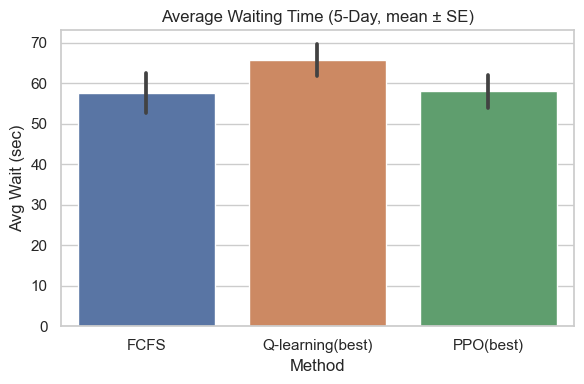

In [82]:
import numpy as np
import pandas as pd

# Env training 8 hrs
env_train = CallCenterEnv(hours=8, dt=5.0, queue_cap=50, seed=0)

best_q_params = dict(q_bins=(20,10), alpha=0.2, gamma=0.90, eps=0.10, eps_decay=0.999)
q_agent, q_policy = train_qlearning(env_train, episodes=300, seed=0)


best_ppo_kwargs = dict(learning_rate=1e-5, gamma=0.99, n_steps=4096, ent_coef=0.0, clip_range=0.2)
# PPO training 8 hrs
def make_env_8h():
    return CallCenterEnv(hours=8, dt=5.0, queue_cap=50, seed=42)
try:
    from stable_baselines3 import PPO
    from stable_baselines3.common.vec_env import DummyVecEnv
except ImportError:
    raise ImportError("Please install stable-baselines3 and shimmy")

vec_env = DummyVecEnv([make_env_8h])
ppo_model = PPO("MlpPolicy", vec_env, seed=0, verbose=0, **best_ppo_kwargs)
ppo_model.learn(total_timesteps=80_000)

def ppo_policy(obs):
    act, _ = ppo_model.predict(obs, deterministic=True)
    return int(act)

# Env setup, 5days
env_eval_5d = CallCenterEnv(hours=24*5, dt=5.0, queue_cap=50, seed=123)

fcfs_policy = lambda obs: 0       
ql_policy  = q_policy     
ppo_pol    = ppo_policy

def run_eval(name, policy, episodes=3, seed=1000):
    df = evaluate_policy(env_eval_5d, policy_fn=policy, episodes=episodes, seed=seed)
    df["method"] = name
    return df

df_fcfs = run_eval("FCFS", fcfs_policy, episodes=3, seed=1000)
df_ql   = run_eval("Q-learning(best)", ql_policy, episodes=3, seed=2000)
df_ppo  = run_eval("PPO(best)", ppo_pol, episodes=3, seed=3000)

final_df = pd.concat([df_fcfs, df_ql, df_ppo], ignore_index=True)
final_df.to_csv("final_eval_5days.csv", index=False)
print("Saved: final_eval_5days.csv")

summary = (final_df
           .groupby("method")[["avg_wait","drop_rate","served","arrivals"]]
           .agg(["mean","std"])
           .round(2))
print("\n=== 5-Day Evaluation Summary (mean ± std) ===")
print(summary)


plt.figure(figsize=(6,4))
sns.barplot(data=final_df, x="method", y="avg_wait", errorbar="se")
plt.title("Average Waiting Time (5-Day, mean ± SE)")
plt.xlabel("Method")
plt.ylabel("Avg Wait (sec)")
plt.tight_layout()
plt.savefig("avg_wait_5day_compare.png", dpi=150)
plt.show()

Saved: final_eval_10days_lambdaX5.csv
                       avg_wait  drop_rate   served  arrivals
method                                                       
FCFS (λ×2)               397.29        0.0  6309.00   6315.67
PPO(best, λ×2)           399.10        0.0  6308.67   6315.33
Q-learning(best, λ×2)    515.94        0.0  6305.67   6312.00


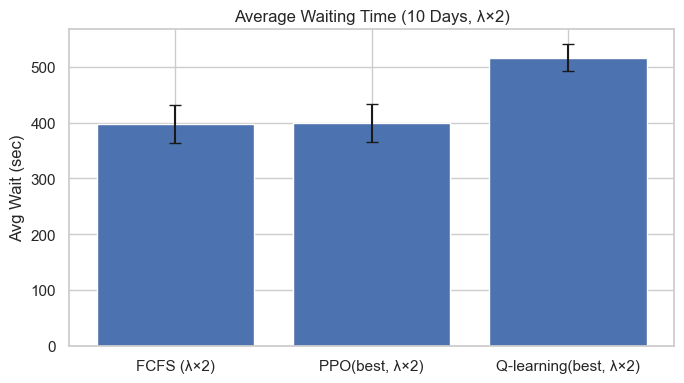

In [90]:
# restore and double the arrival rate
lambda_by_hour_backup = lambda_by_hour.copy()
lambda_by_hour = {h: v * 2 for h, v in lambda_by_hour.items()}

# Env 10days
env_10d = CallCenterEnv(hours=24*10, dt=5.0, queue_cap=50, seed=4321)
fcfs_policy = lambda obs: 0

def run_eval(name, policy, episodes=3, seed=8050):
    df = evaluate_policy(env_10d, policy_fn=policy, episodes=episodes, seed=seed)
    df["method"] = name
    return df

df_fcfs = run_eval("FCFS (λ×2)", fcfs_policy)
df_ql   = run_eval("Q-learning(best, λ×2)", q_policy)
df_ppo  = run_eval("PPO(best, λ×2)", ppo_policy)

res_10d = pd.concat([df_fcfs, df_ql, df_ppo], ignore_index=True)
res_10d.to_csv("final_eval_10days_lambdaX5.csv", index=False)
print("Saved: final_eval_10days_lambdaX5.csv")
print(res_10d.groupby("method")[["avg_wait","drop_rate","served","arrivals"]].mean().round(2))

summary = (res_10d.groupby("method")["avg_wait"]
           .agg(mean="mean", sem=lambda s: s.std(ddof=1)/np.sqrt(len(s)))
           .reset_index())

plt.figure(figsize=(7,4))
x = np.arange(len(summary))
plt.bar(x, summary["mean"], yerr=summary["sem"], capsize=4)
plt.xticks(x, summary["method"])
plt.ylabel("Avg Wait (sec)")
plt.title("Average Waiting Time (10 Days, λ×2)")
plt.tight_layout()
plt.savefig("avg_wait_10days_lambdaX5.png", dpi=150)
plt.show()

#reset
lambda_by_hour = lambda_by_hour_backup